![image.png](plots/california_housing_intro.png)

El contenido de esta libreta está basado en el libro 

* [Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2nd Edition](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/). Capítulo 2

Trabajaremos con un conjunto de datos que contiene información acerca de las casas en distintos distritos del estado de California. Entre otras variables, tendremos la población, los ingresos medianos del barrio, número medio de habitaciones por casa, etc. Con esta información, nuestro objetivo será intentar predecir el precio mediano de las casas de un barrio. Empecemos por cargar los paquetes básicos y acceder al conjunto de datos:

# Carga de datos
___

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(5) # Los resultados del notebook serán los mismos en cada ejecución

In [2]:
housing = pd.read_csv('data/housing.csv')

housing.head()

,longitude,latitude,population,households,housing_median_age,median_income,ocean_proximity,population_per_household,bedrooms_per_household,rooms_per_household,median_house_value
0,-122.23,37.88,322.0,126.0,41.0,8.3252,NEAR BAY,2.555556,0.146591,6.984127,452600.0
1,-122.22,37.86,2401.0,1138.0,21.0,8.3014,NEAR BAY,2.109842,0.155797,6.238137,358500.0
2,-122.24,37.85,496.0,177.0,52.0,7.2574,NEAR BAY,2.802260,0.129516,8.288136,352100.0
3,-122.25,37.85,558.0,219.0,52.0,5.6431,NEAR BAY,2.547945,0.184458,5.817352,341300.0
4,-122.25,37.85,565.0,259.0,52.0,3.8462,NEAR BAY,2.181467,0.172096,6.281853,342200.0


In [3]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   longitude                 20640 non-null  float64
 1   latitude                  20640 non-null  float64
 2   population                20640 non-null  float64
 3   households                20640 non-null  float64
 4   housing_median_age        20640 non-null  float64
 5   median_income             20640 non-null  float64
 6   ocean_proximity           20640 non-null  object 
 7   population_per_household  20640 non-null  float64
 8   bedrooms_per_household    20640 non-null  float64
 9   rooms_per_household       20640 non-null  float64
 10  median_house_value        20640 non-null  float64
dtypes: float64(10), object(1)
memory usage: 1.7+ MB


Tenemos un conjunto de datos con 11 variables. Una, `median_house_value` es la variable respuesta que queremos predecir, y de las otras 10, tenemos 1 categórca (`ocean_proximity`) y 9 numéricas. Ya que tenemos la `longitud` y `latitud` de los barrios del conjunto de datos, representemoslos gráficamente de forma que el color dependa de la variable respuesta.

# Visualización inicial
___

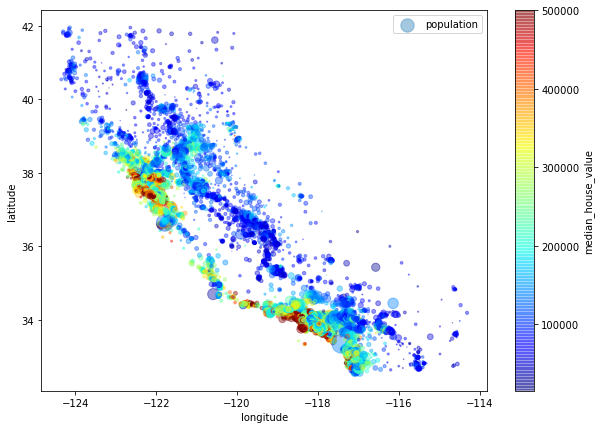

In [4]:
p = housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
             s=housing["population"]/100, label="population", figsize=(10,7),
             c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
             sharex=False)

Podemos ver claramente que el precio es mucho más alto en la costa, alrededor de Los Ángeles y San Francisco. Veamos los scatterplots entre la variable respuesta y las demás variables, para estudiar cuales pueden estar más relacionadas.

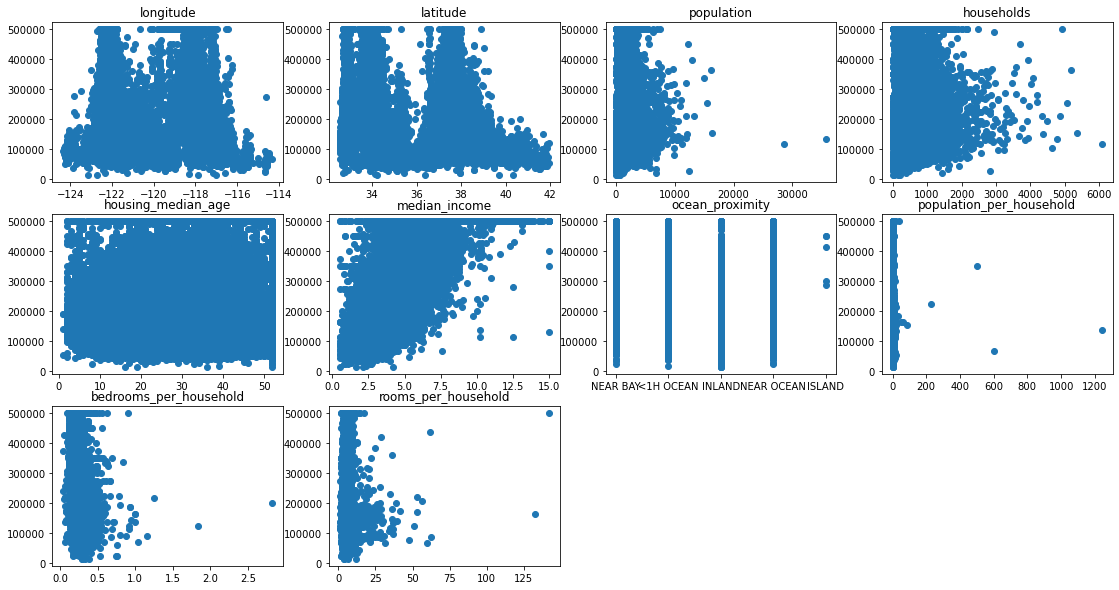

In [5]:
var_names = [var for var in housing.columns if var != 'median_house_value']

plt.figure(figsize=(19,10))
for idx, var in enumerate(var_names):
    plt.subplot(3, 4, idx+1)
    plt.scatter(housing[var], housing['median_house_value'])
    plt.title(var)

Vemos que la variable más relacionada con la respuesta parece ser el `median_income`. Veamos también las correlaciones entre la variable respuesta y las demás variables:


In [6]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.688075
rooms_per_household         0.151948
housing_median_age          0.105623
households                  0.065843
population_per_household   -0.023737
population                 -0.024650
longitude                  -0.045967
latitude                   -0.144160
bedrooms_per_household     -0.233303
Name: median_house_value, dtype: float64

Vemos que efectivamente, la variable más correlacionada es `median_income`, seguida (con una correlación negativa) por `bedrooms_per_household`. El que las correlaciones sean tan bajas nos hace prever que los resultados de nuestros modelos de predicción no serán muy buenos. A continuación veamos la relación entre la variable categórica `ocean_proximity` y la respuesta.

<AxesSubplot:>

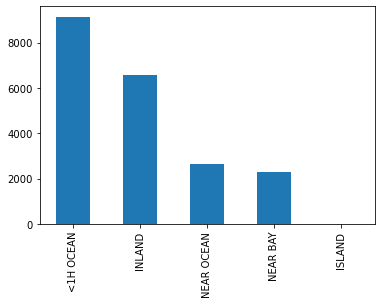

In [7]:
housing['ocean_proximity'].value_counts().plot(kind='bar')

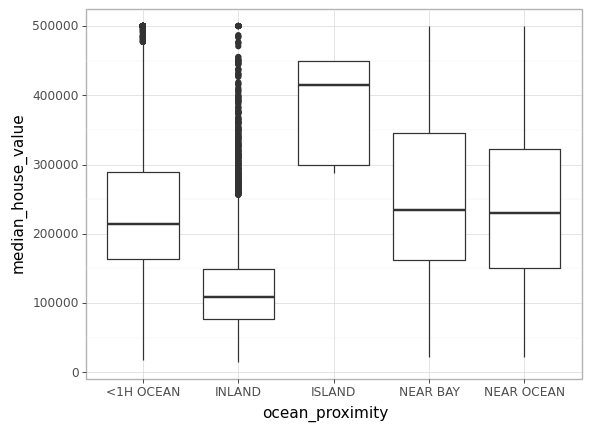

<ggplot: (125656885285)>

In [8]:
from plotnine import *

(ggplot(data=housing, mapping=aes(x='ocean_proximity', y='median_house_value')) + geom_boxplot() + theme_light()) 

### <font color='D12828'> Ejercicio: </font>
1. Obtén un histograma de la variable respuesta `median_house_value`. Pista: usa la función `plt.hist`

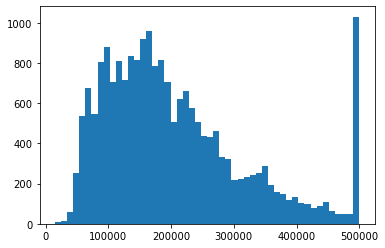

In [9]:
# Ejercicio

p = plt.hist(housing['median_house_value'], bins=50)

# Preprocesado
___

### <font color='D12828'> Ejercicio: </font>
1. Divide el dataframe `housing` en la parte de los predictores `X`, y la respuesta `y`. Pista: la variable respuesta es `median_house_value`
2. Divide `X` e `y` en un conjunto de train y otro de test de forma que el `train_size` sea de 5000 observaciones

In [10]:
# Ejercicio

from sklearn.model_selection import train_test_split

X = housing.drop('median_house_value', axis=1)
y = housing['median_house_value']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=5000, random_state=42)

## Estandarización

Hemos visto que cuando tratamos con variables numéricas, normalmente es recomendable estandarizarlas para que la escala de las unidades no afecten a la capacidad de hacer predicciones de los algoritmos, pero solo tiene sentido estandarizar las variables que sean numéricas.

### <font color='D12828'> Ejercicio: </font>
1. Crea un dataframe llamado `X_num` solo con las variables numéricas de `X_train` (elimina `ocean_proximity`)
2. Estandariza el conjunto `X_num` usando la función `sklearn.preprocessing.StandardScaler`

In [11]:
# Ejercicio
from sklearn.preprocessing import StandardScaler

X_num = X_train.drop('ocean_proximity', axis=1)

scaler = StandardScaler()

X_num = scaler.fit_transform(X_num)

## Ona hot encoding

Por otro lado, tenemos la variable categórica `ocean_proximity`. La mayoría de algoritmos de sklearn no aceptan variables que no sean numéricas, por lo que para incorporar estas variables categóricas es necesario codificarlas. Para ello usaremos la conocida como __one-hot encoding__, utilizada en prácticamente todos los modelos de ML, directa o indirectamente, para incorporar variables categóricas:

![image.png](plots/one_hot_encoding.png)

La idea es sencilla: dada una variable categórica con k clases, se construyen k variables numéricas que codifican con 1 o 0 cada clase. Esta codificación ya está programada en sklearn, veamos como usarla:

In [12]:
from sklearn.preprocessing import OneHotEncoder

X_cat = X_train[["ocean_proximity"]]

cat_encoder = OneHotEncoder()
X_cat_onehot = cat_encoder.fit_transform(X_cat)

print(X_cat_onehot.toarray()[0:5, 0:5], '\n')

print(cat_encoder.categories_)

[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]] 

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)]


## Preprocesado con pipelines

Ahora estamos haciendo sobre una parte de las variables (las numéricas) un tipo de preprocesado, y sobre otra parte de las variables (la categórica) otro preprocesado. Veamos cómo podemos unificar todo este proceso usando un tipo especial de pipeline llamado `ColumnTransformer`, que nos permite aplicar funciones diferentes a columnas diferentes de los datos:

In [13]:
from sklearn.compose import ColumnTransformer

num_attribs = [var for var in X_train if var != 'ocean_proximity']
cat_attribs = ['ocean_proximity']

print(num_attribs, '\n')
print(cat_attribs)

['longitude', 'latitude', 'population', 'households', 'housing_median_age', 'median_income', 'population_per_household', 'bedrooms_per_household', 'rooms_per_household'] 

['ocean_proximity']


In [14]:

full_pipeline = ColumnTransformer([
    # Preprocesado sobre variables numéricas
    ('num', StandardScaler(), num_attribs),
    
    # Preprocesado sobre variables categóricas
    ('cat', OneHotEncoder(), cat_attribs),
])

X_train_preproces = full_pipeline.fit_transform(X_train)

La ventaja principal de construir un pipeline de este estilo viene sobre todo cuando necesitamos llevar a cabo el mismo preprocesado más de una vez, por ejemplo, sobre el conjunto de datos de test, o al recibir nuevas observaciones sobre las que queramos hacer predicciones.

### <font color='D12828'> Ejercicio: </font>
1. Lleva a cabo el preprocesado del conjunto de datos `X_test` y almacena el resultado en `X_test_preproces`. Recuerda que queremos escalar los datos del test en base a la información del train.

In [15]:
# Ejercicio

X_test_preproces = full_pipeline.transform(X_test)

# Construcción del modelo
___

Ahora que ya tenemos el conjunto de datos preparado, es hora de construir el modelo. Dado que la variable respuesta es numérica, se trata de un problema de regresión, por lo que construiremos una SVM de regresión.

In [16]:
from sklearn.svm import SVR

# Construcción del modelo
svr_lineal = SVR(kernel='linear')
svr_lineal.fit(X_train_preproces, y_train)

# Predicción 
prediccion = svr_lineal.predict(X_test_preproces)

print(f'Predicción {np.round(prediccion[11:14], 0)}')
print(f'Valor      {y_test[11:14].values}')


Predicción [179854. 181394. 180918.]
Valor      [253900. 215100. 220500.]


Veamos una métrica del error de este modelo. Para ello usaremos el `mean_squared_error`, o error cuadrático medio. Este error calcula la diferencia entre las predicciones y el verdadero valor de las observaciones, y después las eleva al cuadrado. Al elevarlas al cuadrado se consigue que todos los errores sean números positivos, y por último hace la media de los errores. Es muy habitual tomar después la raiz de este error,   para devolver el error a las unidades originales (es el llamado root mean squared error), ya que es más sencillo de interpretar:

In [17]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, prediccion)
rmse = np.sqrt(mse)

print(f'RMSE: {rmse}')

RMSE: 115796.44557024853


Esto nos está diciendo que nuestras predicciones están aproximadamente 115000\$ alejadas del verdadero valor. Intentemos mejorar este resultado optimizando nuestra SVM.

### <font color='D12828'> Ejercicio: </font>
1. Intentemos mejorar este modelo. Utiliza la función de `sklearn.model_selection.GridSearchCV` para optimizar el tipo de red. En el mallado, incluye una red lineal y optimiza `C`, y una red rbf y optimiza `C` y `gamma`. Utiliza como scoring `neg_mean_squared_error`
2. Obtén el RMSE de las predicciones en la parte de test.

In [18]:
# Ejercicio

from sklearn.model_selection import GridSearchCV

svr = SVR()

param_grid = [{'kernel': ['linear'], 'C':[1e-4, 1e-3, 1e-2, 1e-1, 1, 10]},
             {'kernel':['rbf'], 'C':[1e-3, 1e-2, 1e-1, 1, 10], 'gamma':[1e-4, 1e-3, 1e-2]}]

grid_search = GridSearchCV(svr, param_grid, cv=3, n_jobs=3, verbose=1, scoring='neg_mean_squared_error')
grid_search.fit(X_train_preproces, y_train)

final_model = grid_search.best_estimator_
print(final_model)

Fitting 3 folds for each of 21 candidates, totalling 63 fits
SVR(C=10, kernel='linear')


In [19]:
# Ejercicio

final_predictions = final_model.predict(X_test_preproces)

mse = mean_squared_error(y_test, final_predictions)
rmse = np.sqrt(mse)

print(f'RMSE: {rmse}')

RMSE: 99097.81935451603


# Final
___
Con esto termina nuestro análisis del conjunto de datos de MNIST.

![image.png](plots/fin_svm_2.png)